### Model description and features
XGB model on all users that added product on July 2016,  

Features:
--------
*  xgb model trained on all months on added products and more features
   features generated from last 4 months
   product changes features like: product_exists_atleast_once, product_exists_in_all_months
   product_doesnt_exist_in_all_months, product_removed_in_the_past
   product_added_in_the_past

* features generated from the last four months product subscriptions
* and raw product subscriptions of the past 4 months


In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from scripts.kaggle.helpers import make_submission
import datetime
from tqdm import tqdm
import gc
import itertools
from multiprocessing import Pool
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 16)

%load_ext autotime

Populating the interactive namespace from numpy and matplotlib


In [15]:
TRAIN_MONTH_OLD_4 = '2015_02_28'
TRAIN_MONTH_OLD_3 = '2015_03_28'
TRAIN_MONTH_OLD_2 = '2015_04_28'
TRAIN_MONTH_OLD_1 = '2015_05_28'
TRAIN_MONTH_NEW = '2015_06_28'

TEST_MONTH_OLD_4 = '2016_02_28'
TEST_MONTH_OLD_3 = '2016_03_28'
TEST_MONTH_OLD_2 = '2016_04_28'
TEST_MONTH_OLD_1 = '2016_05_28'
#TEST_MONTH_NEW = '2016_06_28'

TRAIN_FILE_OLD_4 = 'data/train_' + TRAIN_MONTH_OLD_4 + '.csv'
TRAIN_FILE_OLD_3 = 'data/train_' + TRAIN_MONTH_OLD_3 + '.csv'
TRAIN_FILE_OLD_2 = 'data/train_' + TRAIN_MONTH_OLD_2 + '.csv'
TRAIN_FILE_OLD_1 = 'data/train_' + TRAIN_MONTH_OLD_1 + '.csv'
TRAIN_FILE_NEW = 'data/train_' + TRAIN_MONTH_NEW + '.csv'

ADDED_PRODUCTS_FILE = 'data/added_product_' + TRAIN_MONTH_OLD_1 + '.csv'

TEST_FILE_OLD_4 = 'data/train_' + TEST_MONTH_OLD_4 + '.csv'
TEST_FILE_OLD_3 = 'data/train_' + TEST_MONTH_OLD_3 + '.csv'
TEST_FILE_OLD_2 = 'data/train_' + TEST_MONTH_OLD_2 + '.csv'
TEST_FILE_OLD_1 = 'data/train_' + TEST_MONTH_OLD_1 + '.csv'
TEST_FILE_NEW = 'data/test_ver2.csv'

HEADER = ["fecha_dato", "ncodpers", "ind_empleado",
          "pais_residencia", "sexo", "age", "fecha_alta",
          "ind_nuevo", "antiguedad", "indrel", "ult_fec_cli_1t",
          "indrel_1mes", "tiprel_1mes", "indresi", "indext",
          "conyuemp", "canal_entrada", "indfall", "tipodom",
          "cod_prov", "nomprov", "ind_actividad_cliente",
          "renta", "segmento", "ind_ahor_fin_ult1",
          "ind_aval_fin_ult1", "ind_cco_fin_ult1",
          "ind_cder_fin_ult1", "ind_cno_fin_ult1",
          "ind_ctju_fin_ult1", "ind_ctma_fin_ult1",
          "ind_ctop_fin_ult1", "ind_ctpp_fin_ult1",
          "ind_deco_fin_ult1", "ind_deme_fin_ult1",
          "ind_dela_fin_ult1", "ind_ecue_fin_ult1",
          "ind_fond_fin_ult1", "ind_hip_fin_ult1",
          "ind_plan_fin_ult1", "ind_pres_fin_ult1",
          "ind_reca_fin_ult1", "ind_tjcr_fin_ult1",
          "ind_valo_fin_ult1", "ind_viv_fin_ult1",
          "ind_nomina_ult1", "ind_nom_pens_ult1",
          "ind_recibo_ult1"]

time: 15.6 ms


In [16]:
train_old_4 = pd.read_csv(TRAIN_FILE_OLD_4, header=None, names=HEADER)
train_old_3 = pd.read_csv(TRAIN_FILE_OLD_3, header=None, names=HEADER)
train_old_2 = pd.read_csv(TRAIN_FILE_OLD_2, header=None, names=HEADER)
train_old_1 = pd.read_csv(TRAIN_FILE_OLD_1, header=None, names=HEADER)
train_new = pd.read_csv(TRAIN_FILE_NEW, header=None, names=HEADER)

test_old_4 = pd.read_csv(TEST_FILE_OLD_4, header=None, names=HEADER)
test_old_3 = pd.read_csv(TEST_FILE_OLD_3, header=None, names=HEADER)
test_old_2 = pd.read_csv(TEST_FILE_OLD_2, header=None, names=HEADER)
test_old_1 = pd.read_csv(TEST_FILE_OLD_1, header=None, names=HEADER)
test_new = pd.read_csv(TEST_FILE_NEW)

added_products = pd.read_csv(ADDED_PRODUCTS_FILE)

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (11,12,15,16,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


time: 1min 7s


In [17]:
for col in HEADER[24:]:
    test_new[col] = [0]*test_new.shape[0]

time: 3.41 s


In [18]:
combined = pd.concat((train_old_4, train_old_3, train_old_2, train_old_1,train_new,
                      test_old_4, test_old_3, test_old_2, test_old_1, test_new)).reset_index(drop=True)
del train_old_4, train_old_3, train_old_2, train_old_1, train_new,\
    test_old_4, test_old_3, test_old_2, test_old_1, test_new

time: 48.2 s


In [6]:
gc.collect()

72

time: 126 ms


In [19]:
def process_data_from_original_dataframe(combined, encoders=None):
    # fixing age
    combined['age'] = pd.to_numeric(combined['age'], errors='coerce')

    combined.loc[combined.age < 18, "age"] = \
        combined.loc[(combined.age > 18) &
                     (combined.age <= 30), "age"].mean(skipna=True)
    combined.loc[combined.age > 100, "age"] = \
        combined.loc[(combined.age > 30) &
                     (combined.age <= 100), "age"].mean(skipna=True)
    combined['age'].fillna(combined['age'].mean(), inplace=True)
    combined['age'] = combined['age'].astype(int)

    # fix ind_nuevo..
    combined.loc[combined.ind_nuevo.isnull(), 'ind_nuevo'] = 1

    # fix antiguedad
    combined['antiguedad'] = pd.to_numeric(combined['antiguedad'],
                                           errors='coerce')
    combined.loc[combined.antiguedad.isnull(), 'antiguedad'] = \
        combined.antiguedad.min()
    combined.loc[combined.antiguedad < 0, 'antiguedad'] = 0

    # fix indrel
    combined.loc[combined.indrel.isnull(), 'indrel'] = 1

    # drop useless cols
    combined.drop(['tipodom', 'cod_prov'], axis=1, inplace=True)

    # fix ind_actividad_cliente
    combined.loc[combined.ind_actividad_cliente.isnull(),
                 "ind_actividad_cliente"] = \
        combined.ind_actividad_cliente.median()

    # fix city name
    combined.loc[combined.nomprov ==
                 "CORU\xc3\x91A, A", "nomprov"] = "CORUNA, A"
    combined.loc[combined.nomprov.isnull(), 'nomprov'] = 'UNKNOWN'

    # fix incomes
    # combined.renta = pd.to_numeric(combined.renta, errors='coerce')
    combined['renta'] = pd.to_numeric(combined['renta'], errors='coerce')

    grouped = combined.groupby('nomprov').\
        agg({'renta': lambda x: x.median(skipna=True)}).reset_index()
    new_incomes = pd.merge(combined, grouped,
                           how='inner',
                           on='nomprov').loc[:, ['nomprov', 'renta_y']]

    new_incomes = new_incomes.\
        rename(columns={"renta_y": "renta"}).\
        sort_values("renta").sort_values("nomprov")

    combined.sort_values("nomprov", inplace=True)
    combined = combined.reset_index()
    new_incomes = new_incomes.reset_index()
    combined.loc[combined.renta.isnull(), "renta"] = \
        new_incomes.loc[combined.renta.isnull(), "renta"].median()
    combined.sort_values(by='fecha_dato', inplace=True)

    # rest of the columns
    string_data = combined.select_dtypes(include=["object"])
    missing_columns = [col for col in string_data
                       if string_data[col].isnull().any()]
    del string_data

    combined.loc[combined.indfall.isnull(), 'indfall'] = 'N'
    combined.loc[combined.tiprel_1mes.isnull(), 'tiprel_1mes'] = 'A'
    combined.tiprel_1mes = combined.tiprel_1mes.astype('category')

    map_dict = {
        '1.0': '1',
        '1': '1',
        '3.0': '3',
        'P': 'P',
        3.0: '3',
        2.0: '2',
        '3': '3',
        '2.0': '2',
        '4.0': '4',
        '4': '4',
        '2': '2',
        1.0: '1',
        4.0: '4'
    }

    combined.indrel_1mes.fillna('P', inplace=True)
    combined.indrel_1mes = combined.indrel_1mes.apply(lambda x: map_dict[x])
    combined.indrel_1mes = combined.indrel_1mes.astype('category')

    unknown_cols = [col for col in missing_columns if
                    col not in ['indfall', 'tiprel_1mes', 'indrel_1mes']]
    for col in unknown_cols:
        combined.loc[combined[col].isnull(), col] = "UNKNOWN"

    # feature cols
    feature_cols = combined.iloc[:1, ].filter(regex="ind_+.*ult.*").\
        columns.values
    for col in feature_cols:
        combined.loc[combined[col].isnull(), col] = 0
        combined[col] = combined[col].astype(int)

    del combined['ult_fec_cli_1t'], combined['fecha_alta']
    encoder_cols = ['sexo', 'indrel_1mes', 'pais_residencia', 'ind_empleado',
                'segmento', 'tiprel_1mes', 'indresi', 'indext', 'conyuemp',
                'canal_entrada', 'indfall', 'nomprov']
    if encoders == None:
        encoders = []
        for col in encoder_cols:
            temp_enc = LabelEncoder()
            temp_enc.fit(combined[col])
            combined[col] = temp_enc.transform(combined[col])
            encoders.append(temp_enc)
    else:
        for i in range(len(encoders)):
            combined[encoder_cols[i]] = encoders[i].transform(combined[encoder_cols[i]])
        
    return combined, encoders



time: 382 ms


In [20]:
combined, encoders = process_data_from_original_dataframe(combined)

time: 6min 25s


In [40]:
train_old_4 = combined.loc[combined.fecha_dato == '2015-02-28', :].reset_index(drop=True)
train_old_3 = combined.loc[combined.fecha_dato == '2015-03-28', :].reset_index(drop=True)
train_old_2 = combined.loc[combined.fecha_dato == '2015-04-28', :].reset_index(drop=True)
train_old_1 = combined.loc[combined.fecha_dato == '2015-05-28', :].reset_index(drop=True)
train_new = combined.loc[combined.fecha_dato == '2015-06-28', :].reset_index(drop=True)

test_old_4 = combined.loc[combined.fecha_dato == '2016-02-28', :].reset_index(drop=True)
test_old_3 = combined.loc[combined.fecha_dato == '2016-03-28', :].reset_index(drop=True)
test_old_2 = combined.loc[combined.fecha_dato == '2016-04-28', :].reset_index(drop=True)
test_old_1 = combined.loc[combined.fecha_dato == '2016-05-28', :].reset_index(drop=True)
test_new = combined.loc[combined.fecha_dato == '2016-06-28', :].reset_index(drop=True)
del combined
gc.collect()

1491

time: 25.5 s


In [41]:
del train_old_1['index'], train_old_2['index'], train_old_3['index'], train_old_4['index'], train_new['index'], test_old_1['index'], test_old_2['index'], test_old_3['index'], test_old_4['index'], test_new['index']
del train_old_1['fecha_dato'], train_old_2['fecha_dato'], train_old_3['fecha_dato'], train_old_4['fecha_dato'], train_new['fecha_dato'], test_old_1['fecha_dato'], test_old_2['fecha_dato'], test_old_3['fecha_dato'], test_old_4['fecha_dato'], test_new['fecha_dato']

time: 3.79 s


In [11]:
for df in train_old_4, train_old_3, train_old_2, train_old_1, train_new, test_old_4, test_old_3, test_old_2, test_old_1, test_new:
    print df.shape

(627394, 43)
(629209, 43)
(630367, 43)
(631957, 43)
(632110, 43)
(920904, 43)
(925076, 43)
(928274, 43)
(931453, 43)
(929615, 43)
time: 1.63 ms


In [42]:
train_old_4.set_index('ncodpers', inplace=True)
train_old_3.set_index('ncodpers', inplace=True)
train_old_2.set_index('ncodpers', inplace=True)
train_old_1.set_index('ncodpers', inplace=True)
train_new.set_index('ncodpers', inplace=True)

test_old_4.set_index('ncodpers', inplace=True)
test_old_3.set_index('ncodpers', inplace=True)
test_old_2.set_index('ncodpers', inplace=True)
test_old_1.set_index('ncodpers', inplace=True)
test_new.set_index('ncodpers', inplace=True)

time: 5.12 s


## Features
* What products got added in the last 4 months
* What products got removed in the last 4 months
* What products were there the whole period
* What products were there for only partial period
* What products the last month doesn't have when compared to the product history
* Identify the user attributes to keep track of similar to above product history
* Total number of products

In [43]:
added_products.set_index('ncodpers', inplace=True)
print added_products.shape

(41745, 1)
time: 7.4 ms


In [51]:
train = pd.DataFrame()
train['ncodpers'] = added_products.index
train.set_index('ncodpers', inplace=True)

test = pd.DataFrame()
test['ncodpers'] = test_new.index
test.set_index('ncodpers', inplace=True)

for col in train_new.columns[:18]:
    train[col] = train_new.loc[added_products.index, col]
    test[col] = test_new.loc[test_new.index, col]
    
for col in HEADER[24:]:
    train['current_' + col] = train_old_1.loc[added_products.index, col]
    test['current_' + col] = test_old_1.loc[test_new.index, col]
    


time: 15.9 s


In [94]:
def get_all_past_values_of_col(ind, col, old_dfs):
    """
    old dfs must go from current to old months
    """
#     print col, ind
    values = []
    temp = None
    for df in old_dfs:
        try:
            value = df.ix[ind, col]
            if value.shape == ():
                values.append(value)
            else:
                value = list(value)[0]
                values.append(value)
            temp = value
        except KeyError:
            values.append(value)
    return values

time: 5.66 ms


In [22]:
def is_producted_added_in_past(past_values):
    """
    products go from current month to older months
    """
    current = past_values[0]
    is_added = False
    for v in past_values[1:]:
        is_added = (current ^ v) & current
        current = v
        if is_added:
            return is_added
    return is_added

def is_product_removed_in_past(past_values):
    return is_producted_added_in_past(list(reversed(past_values)))

time: 5.1 ms


In [23]:
def get_product_features(past_values):
    """
    takes in values from current month to old months and computes various features
    product_exists_atleast_once, product_exists_in_all_months, product_doesnt_exist_in_all_months
    product_removed_in_the_past, product_added_in_the_past
    """
    product_exists_atleast_once = any(past_values)
    product_exists_in_all_months = all(past_values)
    product_doesnt_exist_in_all_months = all([not x for x in past_values])
    product_removed_in_the_past = is_product_removed_in_past(past_values[1:])
    product_removed_recently = is_product_removed_in_past(past_values[:2])
    product_added_in_the_past = is_producted_added_in_past(past_values[1:])
    product_added_recently = is_producted_added_in_past(past_values[:2])

    return product_exists_atleast_once, product_exists_in_all_months, product_doesnt_exist_in_all_months, product_removed_in_the_past, product_added_in_the_past, product_removed_recently, product_added_recently

time: 12.7 ms


In [25]:
# get_product_features(741176, HEADER[26])
def fill_product_features_from_history(df, *args):
    for i in tqdm(df.index):
        for col in HEADER[24:]:
            past_values = get_all_past_values_of_col(i, col, args)
            product_features = get_product_features(past_values)
            df.set_value(i, 'pf1_exists_at_least_1_' + col, product_features[0])
            df.set_value(i, 'pf2_exists_all_months_' + col, product_features[1])
            df.set_value(i, 'pf3_doesnt_exist_at_all_' + col, product_features[2])
            df.set_value(i, 'pf4_product_removed_in_past_' + col, product_features[3])
            df.set_value(i, 'pf5_product_added_in_past_' + col, product_features[4])
            df.set_value(i, 'pf6_product_removed_recently_' + col, product_features[5])
            df.set_value(i, 'pf7_product_added_recently_' + col, product_features[6])
    for i, df_old in enumerate(args[1:]):
        for col in HEADER[24:]:
            df['old_' + str(i+1) + '_' + col] = df_old.loc[df.index, col]

time: 8.58 ms


In [50]:
train_old_1.columns

Index([u'ind_empleado', u'pais_residencia', u'sexo', u'age', u'ind_nuevo',
       u'antiguedad', u'indrel', u'indrel_1mes', u'tiprel_1mes', u'indresi',
       u'indext', u'conyuemp', u'canal_entrada', u'indfall', u'nomprov',
       u'ind_actividad_cliente', u'renta', u'segmento', u'ind_ahor_fin_ult1',
       u'ind_aval_fin_ult1', u'ind_cco_fin_ult1', u'ind_cder_fin_ult1',
       u'ind_cno_fin_ult1', u'ind_ctju_fin_ult1', u'ind_ctma_fin_ult1',
       u'ind_ctop_fin_ult1', u'ind_ctpp_fin_ult1', u'ind_deco_fin_ult1',
       u'ind_deme_fin_ult1', u'ind_dela_fin_ult1', u'ind_ecue_fin_ult1',
       u'ind_fond_fin_ult1', u'ind_hip_fin_ult1', u'ind_plan_fin_ult1',
       u'ind_pres_fin_ult1', u'ind_reca_fin_ult1', u'ind_tjcr_fin_ult1',
       u'ind_valo_fin_ult1', u'ind_viv_fin_ult1', u'ind_nomina_ult1',
       u'ind_nom_pens_ult1', u'ind_recibo_ult1'],
      dtype='object')

time: 4.16 ms


In [114]:
fill_product_features_from_history(train, train_old_1, train_old_2, train_old_3, train_old_4)
fill_user_lag_features_from_history(train, train_old_1, train_old_2, train_old_3, train_old_4)

100%|██████████| 41745/41745 [02:28<00:00, 281.63it/s]


time: 2min 38s


In [116]:
train['month'] = [6]*train.shape[0]

time: 6.64 ms


# Lag features from user attributes

In [72]:
def is_col_changed_in_past(past_values):
    """
    products go from current month to older months
    """
    current = past_values[0]
    is_changed = False
    no_changed = 0
    for v in past_values[1:]:
        if current != v:
            if not is_changed:
                is_changed = True
            no_changed += 1
        current = v
    return is_changed, no_changed

def get_user_lag_features(past_values):
    changed_recently, no_changed_recently = is_col_changed_in_past(past_values[:2])
    changed_earlier, no_changed_earlier = is_col_changed_in_past(past_values[1:])
    return changed_recently, changed_earlier, no_changed_recently+no_changed_earlier
# get_product_features(741176, HEADER[26])
# tier1: age, ind_nuevo, antiguedad,  indrel_1mes, tiprel_1mes,  canal_entrada, 
#  ind_actividad_cliente, segmento
# tier2: pais_residencia,indrel,indresi, indext, conyuemp,indfall,nomprov,
user_attributes = ['age', 'ind_nuevo', 'antiguedad', 'indrel_1mes', 'tiprel_1mes',
                   'canal_entrada', 'ind_actividad_cliente', 'segmento',
                   'pais_residencia', 'indrel', 'indresi', 'indext', 'conyuemp',
                   'indfall', 'nomprov']
def fill_user_lag_features_from_history(df, *args):
    for i in tqdm(df.index):
        for col in user_attributes:
#             print col
            past_values = get_all_past_values_of_col(i, col, [df] + list(args))
#             print past_values
            user_features = get_user_lag_features(past_values)
            df.set_value(i, 'uf1_changed_recently_' + col, user_features[0])
            df.set_value(i, 'uf2_changed_earlier_' + col, user_features[1])
            df.set_value(i, 'uf3_times_changed_' + col, user_features[2])
    for i, df_old in enumerate(args):
        for col in user_attributes:
            df['old_' + str(i+1) + '_' + col] = df_old.loc[df.index, col]

time: 19 ms


# Not just June 2015 data for training, include all the training samples

In [27]:
def get_file_string_from_train_data(train_data):
    date_time = datetime.datetime(train_data[0], train_data[1], 28)
    return '_'.join(str(date_time.date()).split('-'))

def get_date_string_from_train_data(train_data):
    date_time = datetime.datetime(train_data[0], train_data[1], 28)
    return '-'.join(str(date_time.date()).split('-'))

def subtract_one_month(train_data):
    if train_data[1] == 1:
        return 2015, 12
    else:
        return train_data[0], train_data[1] - 1
    
som = subtract_one_month

time: 8.52 ms


In [ ]:
class StateLoader(object):
    def __init__(self, encoders):
        self.encoders = encoders
    def __call__(self, train_data):
        return generate_train_data_from_train_data_parallel(train_data, self.encoders)
p = Pool(2)
state = StateLoader(encoders)
results = p.map(state, [(2015, 9, 1), (2015, 10, 2)])

In [110]:
def generate_train_data_from_train_data_parallel(train_data, encoders):
    print train_data
    TRAIN_DATA = train_data[:2]

    TRAIN_MONTH_OLD_4 = get_file_string_from_train_data(som(som(som(som(TRAIN_DATA)))))
    TRAIN_MONTH_OLD_3 = get_file_string_from_train_data(som(som(som(TRAIN_DATA))))
    TRAIN_MONTH_OLD_2 = get_file_string_from_train_data(som(som(TRAIN_DATA)))
    TRAIN_MONTH_OLD_1 = get_file_string_from_train_data(som(TRAIN_DATA))
    TRAIN_MONTH_NEW = get_file_string_from_train_data(TRAIN_DATA)


    TRAIN_FILE_OLD_4 = 'data/train_' + TRAIN_MONTH_OLD_4 + '.csv'
    TRAIN_FILE_OLD_3 = 'data/train_' + TRAIN_MONTH_OLD_3 + '.csv'
    TRAIN_FILE_OLD_2 = 'data/train_' + TRAIN_MONTH_OLD_2 + '.csv'
    TRAIN_FILE_OLD_1 = 'data/train_' + TRAIN_MONTH_OLD_1 + '.csv'
    TRAIN_FILE_NEW = 'data/train_' + TRAIN_MONTH_NEW + '.csv'

    ADDED_PRODUCTS_FILE = 'data/added_product_' + TRAIN_MONTH_OLD_1 + '.csv'

    
    train_old_4 = pd.read_csv(TRAIN_FILE_OLD_4, header=None, names=HEADER)
    train_old_3 = pd.read_csv(TRAIN_FILE_OLD_3, header=None, names=HEADER)
    train_old_2 = pd.read_csv(TRAIN_FILE_OLD_2, header=None, names=HEADER)
    train_old_1 = pd.read_csv(TRAIN_FILE_OLD_1, header=None, names=HEADER)
    train_new = pd.read_csv(TRAIN_FILE_NEW, header=None, names=HEADER)

    added_products_temp = pd.read_csv(ADDED_PRODUCTS_FILE)
    
    
    combined = pd.concat((train_old_4, train_old_3, train_old_2, train_old_1,train_new)).reset_index(drop=True)
    del train_old_4, train_old_3, train_old_2, train_old_1, train_new
    gc.collect()

    combined, encoders = process_data_from_original_dataframe(combined, encoders)
    
    train_old_4 = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_OLD_4.split('_')), :].reset_index(drop=True)
    train_old_3 = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_OLD_3.split('_')), :].reset_index(drop=True)
    train_old_2 = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_OLD_2.split('_')), :].reset_index(drop=True)
    train_old_1 = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_OLD_1.split('_')), :].reset_index(drop=True)
    train_new = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_NEW.split('_')), :].reset_index(drop=True)
    
    del combined
    del train_old_1['index'], train_old_2['index'], train_old_3['index'], train_old_4['index'], train_new['index']
    del train_old_1['fecha_dato'], train_old_2['fecha_dato'], train_old_3['fecha_dato'], train_old_4['fecha_dato'], train_new['fecha_dato']
    gc.collect()
    
    train_old_4.set_index('ncodpers', inplace=True)
    train_old_3.set_index('ncodpers', inplace=True)
    train_old_2.set_index('ncodpers', inplace=True)
    train_old_1.set_index('ncodpers', inplace=True)
    train_new.set_index('ncodpers', inplace=True)

    added_products_temp.set_index('ncodpers', inplace=True)
    
    
    train_temp = pd.DataFrame()
    train_temp['ncodpers'] = added_products_temp.index
    train_temp.set_index('ncodpers', inplace=True)

    for col in train_new.columns[:18]:
        train_temp[col] = train_new.loc[added_products_temp.index, col]

    for col in HEADER[24:]:
        train_temp['current_' + col] = train_old_1.loc[added_products_temp.index, col]
        
    fill_product_features_from_history(train_temp, train_old_1, train_old_2, train_old_3, train_old_4)
    fill_user_lag_features_from_history(train_temp, train_old_1, train_old_2, train_old_3, train_old_4)

    
    del train_old_1, train_old_2, train_old_3, train_old_4
    gc.collect()
    train_temp['month'] = [TRAIN_DATA[1]]*train_temp.shape[0]
    
    return (train_data[2], train_temp, added_products_temp)

time: 88.6 ms


In [111]:
result = generate_train_data_from_train_data_parallel((2015, 7, 1), encoders)

(2015, 7, 1)


100%|██████████| 33362/33362 [02:08<00:00, 259.32it/s]


time: 6min 26s


In [112]:
ind, train_temp, added_products_temp = result

time: 1.18 ms


In [117]:
print train_temp.shape
print train.shape

(33362, 388)
(41745, 388)
time: 1.39 ms


In [101]:
def generate_train_data_from_train_data(train_data, encoders, train, added_products):
    print train_data
    TRAIN_DATA = train_data

    TRAIN_MONTH_OLD_4 = get_file_string_from_train_data(som(som(som(som(TRAIN_DATA)))))
    TRAIN_MONTH_OLD_3 = get_file_string_from_train_data(som(som(som(TRAIN_DATA))))
    TRAIN_MONTH_OLD_2 = get_file_string_from_train_data(som(som(TRAIN_DATA)))
    TRAIN_MONTH_OLD_1 = get_file_string_from_train_data(som(TRAIN_DATA))
    TRAIN_MONTH_NEW = get_file_string_from_train_data(TRAIN_DATA)


    TRAIN_FILE_OLD_4 = 'data/train_' + TRAIN_MONTH_OLD_4 + '.csv'
    TRAIN_FILE_OLD_3 = 'data/train_' + TRAIN_MONTH_OLD_3 + '.csv'
    TRAIN_FILE_OLD_2 = 'data/train_' + TRAIN_MONTH_OLD_2 + '.csv'
    TRAIN_FILE_OLD_1 = 'data/train_' + TRAIN_MONTH_OLD_1 + '.csv'
    TRAIN_FILE_NEW = 'data/train_' + TRAIN_MONTH_NEW + '.csv'

    ADDED_PRODUCTS_FILE = 'data/added_product_' + TRAIN_MONTH_OLD_1 + '.csv'

    
    train_old_4 = pd.read_csv(TRAIN_FILE_OLD_4, header=None, names=HEADER)
    train_old_3 = pd.read_csv(TRAIN_FILE_OLD_3, header=None, names=HEADER)
    train_old_2 = pd.read_csv(TRAIN_FILE_OLD_2, header=None, names=HEADER)
    train_old_1 = pd.read_csv(TRAIN_FILE_OLD_1, header=None, names=HEADER)
    train_new = pd.read_csv(TRAIN_FILE_NEW, header=None, names=HEADER)

    added_products_temp = pd.read_csv(ADDED_PRODUCTS_FILE)
    
    
    combined = pd.concat((train_old_4, train_old_3, train_old_2, train_old_1,train_new)).reset_index(drop=True)
    del train_old_4, train_old_3, train_old_2, train_old_1, train_new
    gc.collect()

    combined, encoders = process_data_from_original_dataframe(combined, encoders)
    
    train_old_4 = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_OLD_4.split('_')), :].reset_index(drop=True)
    train_old_3 = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_OLD_3.split('_')), :].reset_index(drop=True)
    train_old_2 = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_OLD_2.split('_')), :].reset_index(drop=True)
    train_old_1 = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_OLD_1.split('_')), :].reset_index(drop=True)
    train_new = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_NEW.split('_')), :].reset_index(drop=True)
    
    del combined
    del train_old_1['index'], train_old_2['index'], train_old_3['index'], train_old_4['index'], train_new['index']
    del train_old_1['fecha_dato'], train_old_2['fecha_dato'], train_old_3['fecha_dato'], train_old_4['fecha_dato'], train_new['fecha_dato']
    gc.collect()
    
    train_old_4.set_index('ncodpers', inplace=True)
    train_old_3.set_index('ncodpers', inplace=True)
    train_old_2.set_index('ncodpers', inplace=True)
    train_old_1.set_index('ncodpers', inplace=True)
    train_new.set_index('ncodpers', inplace=True)

    added_products_temp.set_index('ncodpers', inplace=True)
    
    
    train_temp = pd.DataFrame()
    train_temp['ncodpers'] = added_products_temp.index
    train_temp.set_index('ncodpers', inplace=True)

    for col in train_new.columns[:18]:
        train_temp[col] = train_new.loc[added_products_temp.index, col]

    for col in HEADER[24:]:
        train_temp['current_' + col] = train_old_1.loc[added_products_temp.index, col]
        
    fill_product_features_from_history(train_temp, train_old_1, train_old_2, train_old_3, train_old_4)
    fill_user_lag_features_from_history(train_temp, train_old_1, train_old_2, train_old_3, train_old_4)

    
    del train_old_1, train_old_2, train_old_3, train_old_4
    gc.collect()
    train_temp['month'] = [TRAIN_DATA[1]]*train_temp.shape[0]
    
    print train.shape, train_temp.shape, added_products.shape, added_products_temp.shape
    train = pd.concat((train, train_temp))
    added_products = pd.concat((added_products, added_products_temp))
    print train.shape, train_temp.shape, added_products.shape, added_products_temp.shape
    return encoders, train, added_products

time: 95.9 ms


In [25]:
encoders, train, added_products = generate_train_data_from_train_data((2015, 7), encoders, train, added_products)
encoders, train, added_products = generate_train_data_from_train_data((2015, 8), encoders, train, added_products)
encoders, train, added_products = generate_train_data_from_train_data((2015, 9), encoders, train, added_products)
encoders, train, added_products = generate_train_data_from_train_data((2015, 10), encoders, train, added_products)
encoders, train, added_products = generate_train_data_from_train_data((2015, 11), encoders, train, added_products)
encoders, train, added_products = generate_train_data_from_train_data((2015, 12), encoders, train, added_products)
encoders, train, added_products = generate_train_data_from_train_data((2016, 1), encoders, train, added_products)
encoders, train, added_products = generate_train_data_from_train_data((2016, 2), encoders, train, added_products)
encoders, train, added_products = generate_train_data_from_train_data((2016, 3), encoders, train, added_products)
encoders, train, added_products = generate_train_data_from_train_data((2016, 4), encoders, train, added_products)
encoders, train, added_products = generate_train_data_from_train_data((2016, 5), encoders, train, added_products)

(2015, 7)


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (11,12,15,16,23) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
100%|██████████| 33362/33362 [01:32<00:00, 360.92it/s]


(41745, 283) (33362, 283) (41745, 1) (33362, 1)
(75107, 283) (33362, 283) (75107, 1) (33362, 1)
(2015, 8)


100%|██████████| 29490/29490 [01:36<00:00, 307.02it/s]


(75107, 283) (29490, 283) (75107, 1) (29490, 1)
(104597, 283) (29490, 283) (104597, 1) (29490, 1)
(2015, 9)


100%|██████████| 35696/35696 [01:46<00:00, 335.73it/s]


(104597, 283) (35696, 283) (104597, 1) (35696, 1)
(140293, 283) (35696, 283) (140293, 1) (35696, 1)
(2015, 10)


100%|██████████| 39803/39803 [02:03<00:00, 323.44it/s]


(140293, 283) (39803, 283) (140293, 1) (39803, 1)
(180096, 283) (39803, 283) (180096, 1) (39803, 1)
(2015, 11)


100%|██████████| 35215/35215 [01:48<00:00, 325.27it/s]


(180096, 283) (35215, 283) (180096, 1) (35215, 1)
(215311, 283) (35215, 283) (215311, 1) (35215, 1)
(2015, 12)


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
100%|██████████| 42353/42353 [02:04<00:00, 340.42it/s]


(215311, 283) (42353, 283) (215311, 1) (42353, 1)
(257664, 283) (42353, 283) (257664, 1) (42353, 1)
(2016, 1)


100%|██████████| 30956/30956 [01:28<00:00, 170.45it/s]


(257664, 283) (30956, 283) (257664, 1) (30956, 1)
(288620, 283) (30956, 283) (288620, 1) (30956, 1)
(2016, 2)


100%|██████████| 49024/49024 [02:18<00:00, 354.32it/s]


(288620, 283) (49024, 283) (288620, 1) (49024, 1)
(337644, 283) (49024, 283) (337644, 1) (49024, 1)
(2016, 3)


100%|██████████| 35203/35203 [01:42<00:00, 343.29it/s]


(337644, 283) (35203, 283) (337644, 1) (35203, 1)
(372847, 283) (35203, 283) (372847, 1) (35203, 1)
(2016, 4)


100%|██████████| 32962/32962 [01:34<00:00, 349.50it/s]


(372847, 283) (32962, 283) (372847, 1) (32962, 1)
(405809, 283) (32962, 283) (405809, 1) (32962, 1)
(2016, 5)


100%|██████████| 35843/35843 [01:41<00:00, 354.84it/s]


(405809, 283) (35843, 283) (405809, 1) (35843, 1)
(441652, 283) (35843, 283) (441652, 1) (35843, 1)
time: 43min 33s


In [26]:
for col in HEADER[24:]:
    train['pf1_exists_at_least_1_' + col] = train['pf1_exists_at_least_1_' + col].astype(int)
    train['pf2_exists_all_months_' + col] = train['pf2_exists_all_months_' + col].astype(int)
    train['pf3_doesnt_exist_at_all_' + col] = train['pf3_doesnt_exist_at_all_' + col].astype(int)
    train['pf4_product_removed_in_past_' + col] = train['pf4_product_removed_in_past_' + col].astype(int)
    train['pf5_product_added_in_past_' + col] = train['pf5_product_added_in_past_' + col].astype(int)
    train['pf6_product_removed_recently_' + col] = train['pf6_product_removed_recently_' + col].astype(int)
    train['pf7_product_added_recently_' + col] = train['pf7_product_added_recently_' + col].astype(int)

train.fillna(0, inplace=True)

time: 6.56 s


In [27]:
label_encoder = LabelEncoder()
label_encoder.fit(added_products.added_product)
added_products['encoded_products'] = label_encoder.\
    transform(added_products['added_product'])

time: 612 ms


In [28]:
print train.shape
print added_products.shape

(441652, 283)
(441652, 2)
time: 1.08 ms


In [29]:
gc.collect()

258

time: 36.9 ms


In [30]:
train.head()

,current_ind_empleado,current_pais_residencia,current_sexo,current_age,current_ind_nuevo,current_antiguedad,current_indrel,current_indrel_1mes,current_tiprel_1mes,current_indresi,...,old_3_ind_plan_fin_ult1,old_3_ind_pres_fin_ult1,old_3_ind_reca_fin_ult1,old_3_ind_tjcr_fin_ult1,old_3_ind_valo_fin_ult1,old_3_ind_viv_fin_ult1,old_3_ind_nomina_ult1,old_3_ind_nom_pens_ult1,old_3_ind_recibo_ult1,month
ncodpers,,,,,,,,,,,,,,,,,,,,,
15892,2,36,0,61,0.0,246.0,1.0,0,0,1,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,6
15897,0,36,2,61,0.0,246.0,1.0,0,0,1,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,6
15906,3,36,0,55,0.0,227.0,1.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6
15925,2,36,2,62,0.0,246.0,1.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6
15927,1,36,2,62,0.0,245.0,1.0,0,0,1,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6


time: 27.3 ms


In [31]:
xgb_main = xgb.DMatrix(train, label=added_products.encoded_products)

def map7eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,8)]
    metric = 0.
    for i in range(7):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@7', metric

param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 200
plist = param.items()

evals_result = {}
evallist = [(xgb_main, 'train')]

time: 3.06 s


In [32]:
xgb_model = xgb.train(plist, xgb_main, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.762594
[1]	train-MAP@7:0.761627
[2]	train-MAP@7:0.762813
[3]	train-MAP@7:0.763807
[4]	train-MAP@7:0.76431
[5]	train-MAP@7:0.765227
[6]	train-MAP@7:0.765338
[7]	train-MAP@7:0.766995
[8]	train-MAP@7:0.76726
[9]	train-MAP@7:0.767652
[10]	train-MAP@7:0.768159
[11]	train-MAP@7:0.76856
[12]	train-MAP@7:0.768791
[13]	train-MAP@7:0.768965
[14]	train-MAP@7:0.769275
[15]	train-MAP@7:0.76937
[16]	train-MAP@7:0.769427
[17]	train-MAP@7:0.769604
[18]	train-MAP@7:0.769787
[19]	train-MAP@7:0.769941
[20]	train-MAP@7:0.769998
[21]	train-MAP@7:0.770158
[22]	train-MAP@7:0.770349
[23]	train-MAP@7:0.770661
[24]	train-MAP@7:0.770849
[25]	train-MAP@7:0.770989
[26]	train-MAP@7:0.771207
[27]	train-MAP@7:0.771404
[28]	train-MAP@7:0.771542
[29]	train-MAP@7:0.771605
[30]	train-MAP@7:0.771773
[31]	train-MAP@7:0.771841
[32]	train-MAP@7:0.771947
[33]	train-MAP@7:0.772067
[34]	train-MAP@7:0.772208
[35]	train-MAP@7:0.77238
[36]	train-MAP@7:0.77252
[37]	train-MAP@7:0.772588
[38]	train-MAP@7:0.772688
[3

In [35]:
fill_product_features_from_history(test, test_old_1, test_old_2, test_old_3, test_old_4)

test['month'] = [6]*test.shape[0]

for col in HEADER[24:]:
    test['pf1_exists_at_least_1_' + col] = test['pf1_exists_at_least_1_' + col].astype(int)
    test['pf2_exists_all_months_' + col] = test['pf2_exists_all_months_' + col].astype(int)
    test['pf3_doesnt_exist_at_all_' + col] = test['pf3_doesnt_exist_at_all_' + col].astype(int)
    test['pf4_product_removed_in_past_' + col] = test['pf4_product_removed_in_past_' + col].astype(int)
    test['pf5_product_added_in_past_' + col] = test['pf5_product_added_in_past_' + col].astype(int)
    test['pf6_product_removed_recently_' + col] = test['pf6_product_removed_recently_' + col].astype(int)
    test['pf7_product_added_recently_' + col] = test['pf7_product_added_recently_' + col].astype(int)

test.fillna(0, inplace=True)
print test.shape


100%|██████████| 929615/929615 [29:37<00:00, 523.04it/s]


(929615, 283)
time: 30min 30s


In [36]:
final_test = xgb.DMatrix(test)
preds = xgb_model.predict(final_test)
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 929615/929615 [12:17<00:00, 1260.68it/s]

time: 13min 43s


In [37]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/11.xgb_trained_on_all_months_only_added_users_product_features_generated_from_last_4_months.csv'
description = '11. xgb model 200 iter trained on all months on added products and more features\
               features generated from last 4 months\
               product changes features like: product_exists_atleast_once, product_exists_in_all_months,\
               product_doesnt_exist_in_all_months, product_removed_in_the_past,\
               product_added_in_the_past, product_removed_recently, product_added_recently, and\
               the actual product submission information\n' + str(param)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/11.xgb_trained_on_all_months_only_added_users_product_features_generated_from_last_4_months.csv.zip
uploading to s3 done
Uploading submission data/11.xgb_trained_on_all_months_only_added_users_product_features_generated_from_last_4_months.csv.zip
Upload done
time: 21.9 s


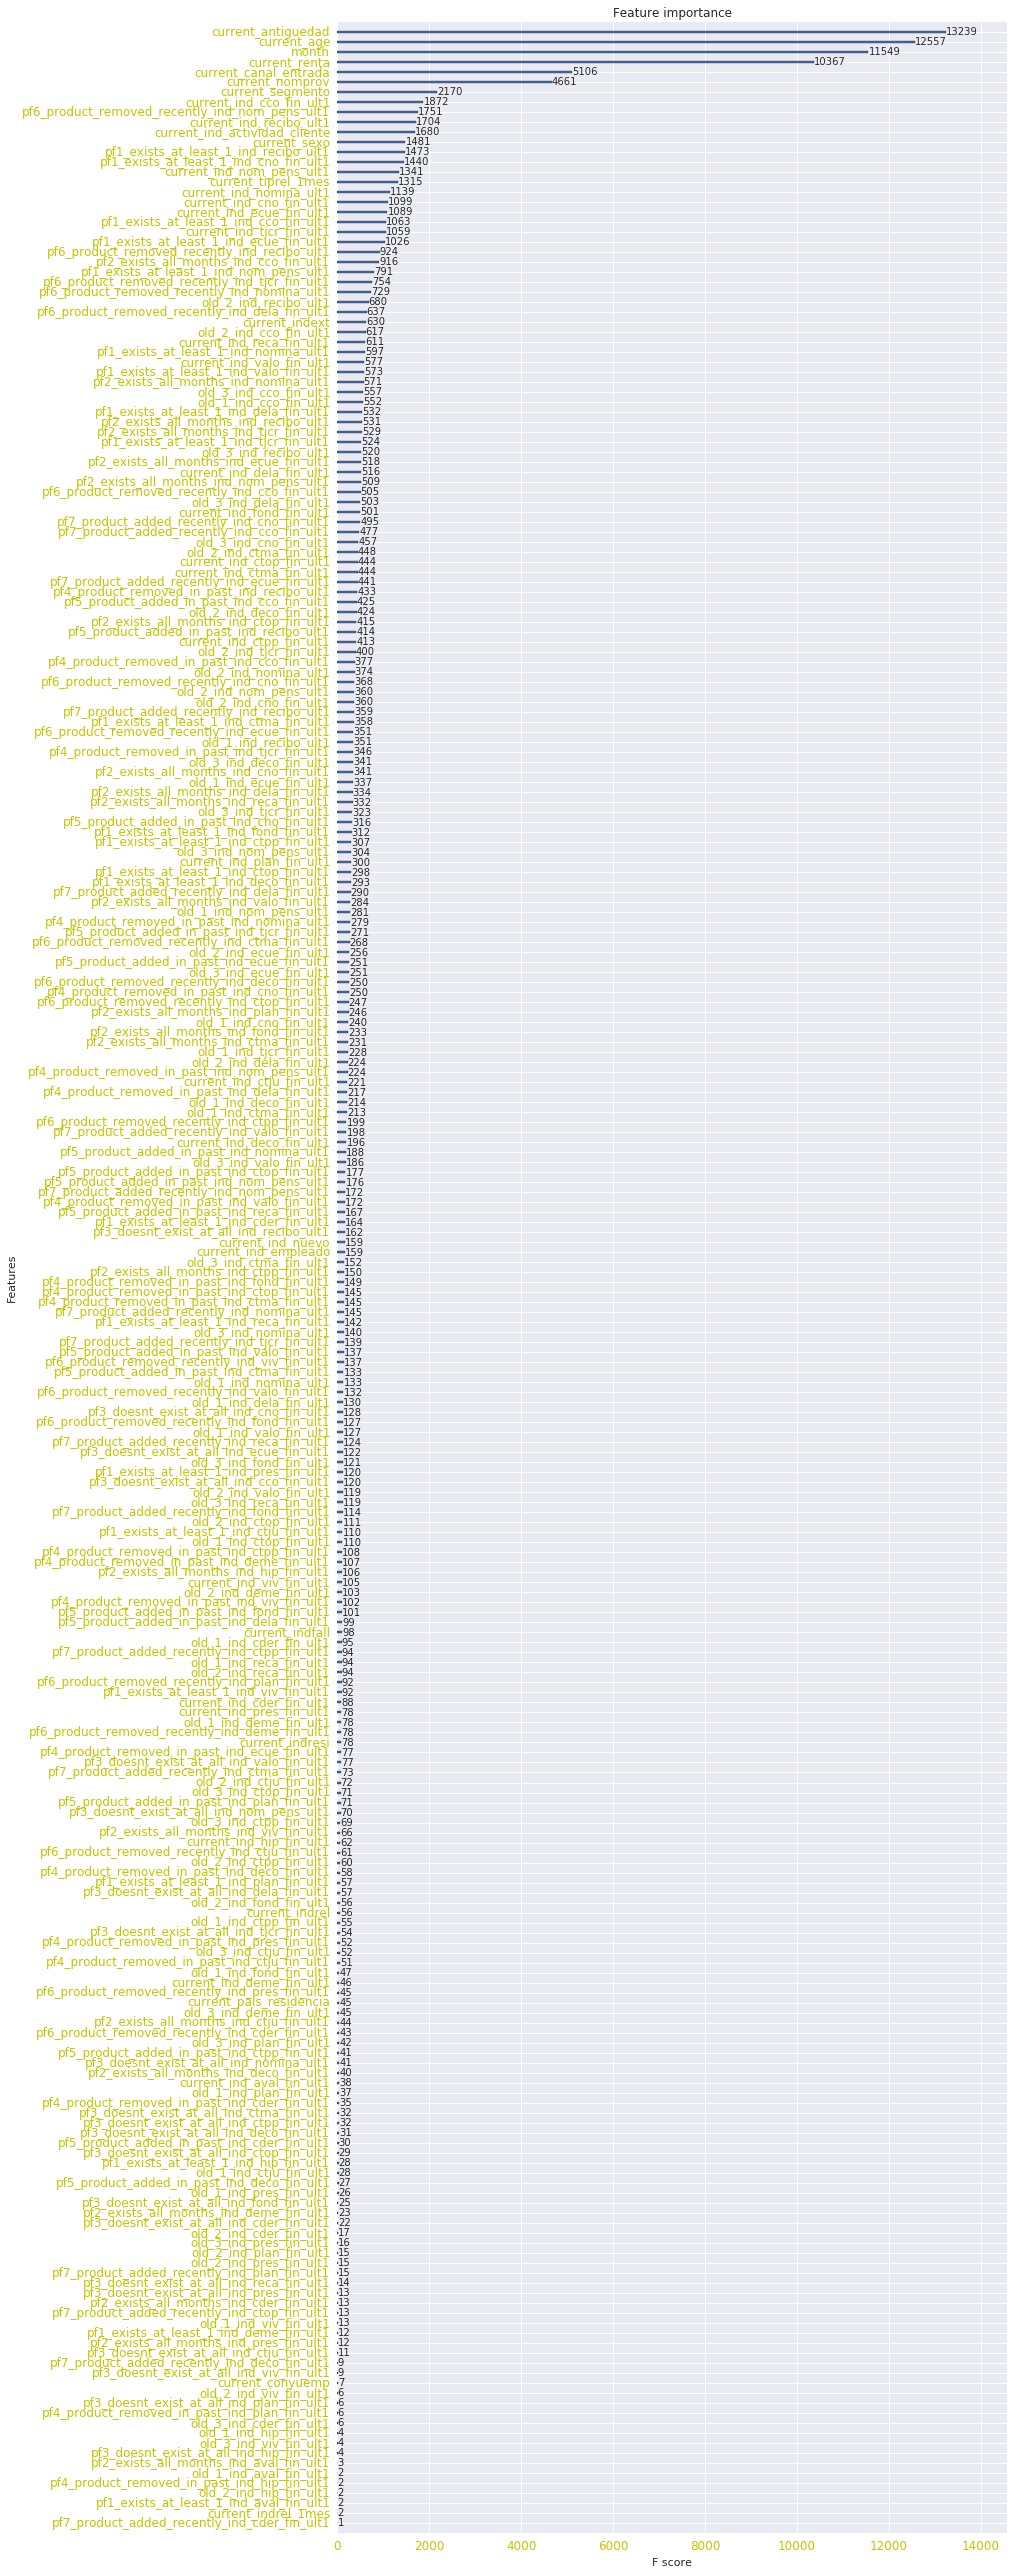

time: 4.68 s


In [47]:
pylab.rcParams['figure.figsize'] = (12, 45)
xgb.plot_importance(xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c4c400")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

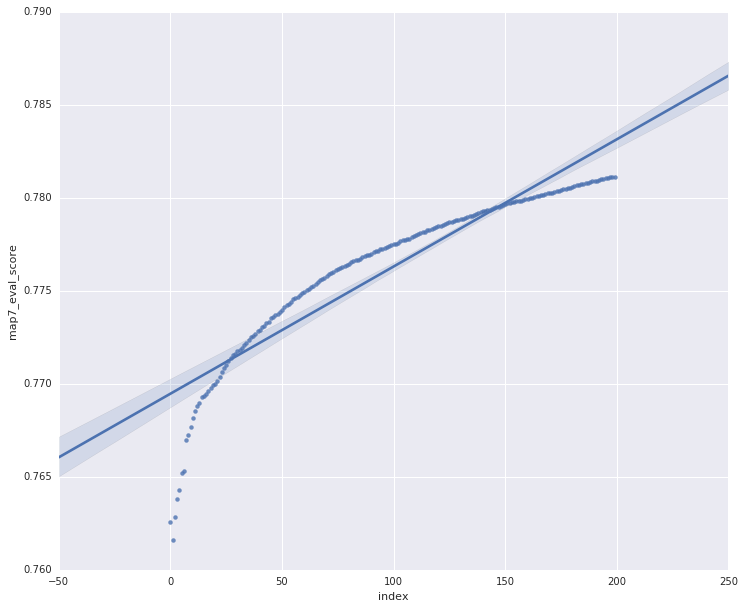

time: 327 ms


In [34]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_eval_score'] = evals_result['train']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
sns.regplot(x='index', y='map7_eval_score', data = p2)

In [39]:
pickle_description = '11. Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/11.xgb_trained_on_all_months_only_added_users_product_features_generated_from_last_4_months.csv.pickle.zip
uploading to s3 done
time: 1min


## now with higher no of iterations n = 300

In [41]:
num_rounds = 300
bst = xgb.train(plist, xgb_main, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.762594
[1]	train-MAP@7:0.761627
[2]	train-MAP@7:0.762813
[3]	train-MAP@7:0.763807
[4]	train-MAP@7:0.76431
[5]	train-MAP@7:0.765227
[6]	train-MAP@7:0.765338
[7]	train-MAP@7:0.766995
[8]	train-MAP@7:0.76726
[9]	train-MAP@7:0.767652
[10]	train-MAP@7:0.768159
[11]	train-MAP@7:0.76856
[12]	train-MAP@7:0.768791
[13]	train-MAP@7:0.768965
[14]	train-MAP@7:0.769275
[15]	train-MAP@7:0.76937
[16]	train-MAP@7:0.769427
[17]	train-MAP@7:0.769604
[18]	train-MAP@7:0.769787
[19]	train-MAP@7:0.769941
[20]	train-MAP@7:0.769998
[21]	train-MAP@7:0.770158
[22]	train-MAP@7:0.770349
[23]	train-MAP@7:0.770661
[24]	train-MAP@7:0.770849
[25]	train-MAP@7:0.770989
[26]	train-MAP@7:0.771207
[27]	train-MAP@7:0.771404
[28]	train-MAP@7:0.771542
[29]	train-MAP@7:0.771605
[30]	train-MAP@7:0.771773
[31]	train-MAP@7:0.771841
[32]	train-MAP@7:0.771947
[33]	train-MAP@7:0.772067
[34]	train-MAP@7:0.772208
[35]	train-MAP@7:0.77238
[36]	train-MAP@7:0.77252
[37]	train-MAP@7:0.772588
[38]	train-MAP@7:0.772688
[3

In [42]:
#final_test = xgb.DMatrix(test)
preds = bst.predict(final_test)
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 929615/929615 [12:21<00:00, 1253.93it/s]

time: 14min 20s


In [43]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/11.1xgb_trained_on_all_months_only_added_users_product_features_generated_from_last_4_months.csv'
description = '11.1 xgb model 300 iter trained on all months on added products and more features\
               features generated from last 4 months\
               product changes features like: product_exists_atleast_once, product_exists_in_all_months,\
               product_doesnt_exist_in_all_months, product_removed_in_the_past,\
               product_added_in_the_past, product_removed_recently, product_added_recently, and\
               the actual product submission information\n' + str(param)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/11.1xgb_trained_on_all_months_only_added_users_product_features_generated_from_last_4_months.csv.zip
uploading to s3 done
Uploading submission data/11.1xgb_trained_on_all_months_only_added_users_product_features_generated_from_last_4_months.csv.zip
Upload done
time: 17.8 s


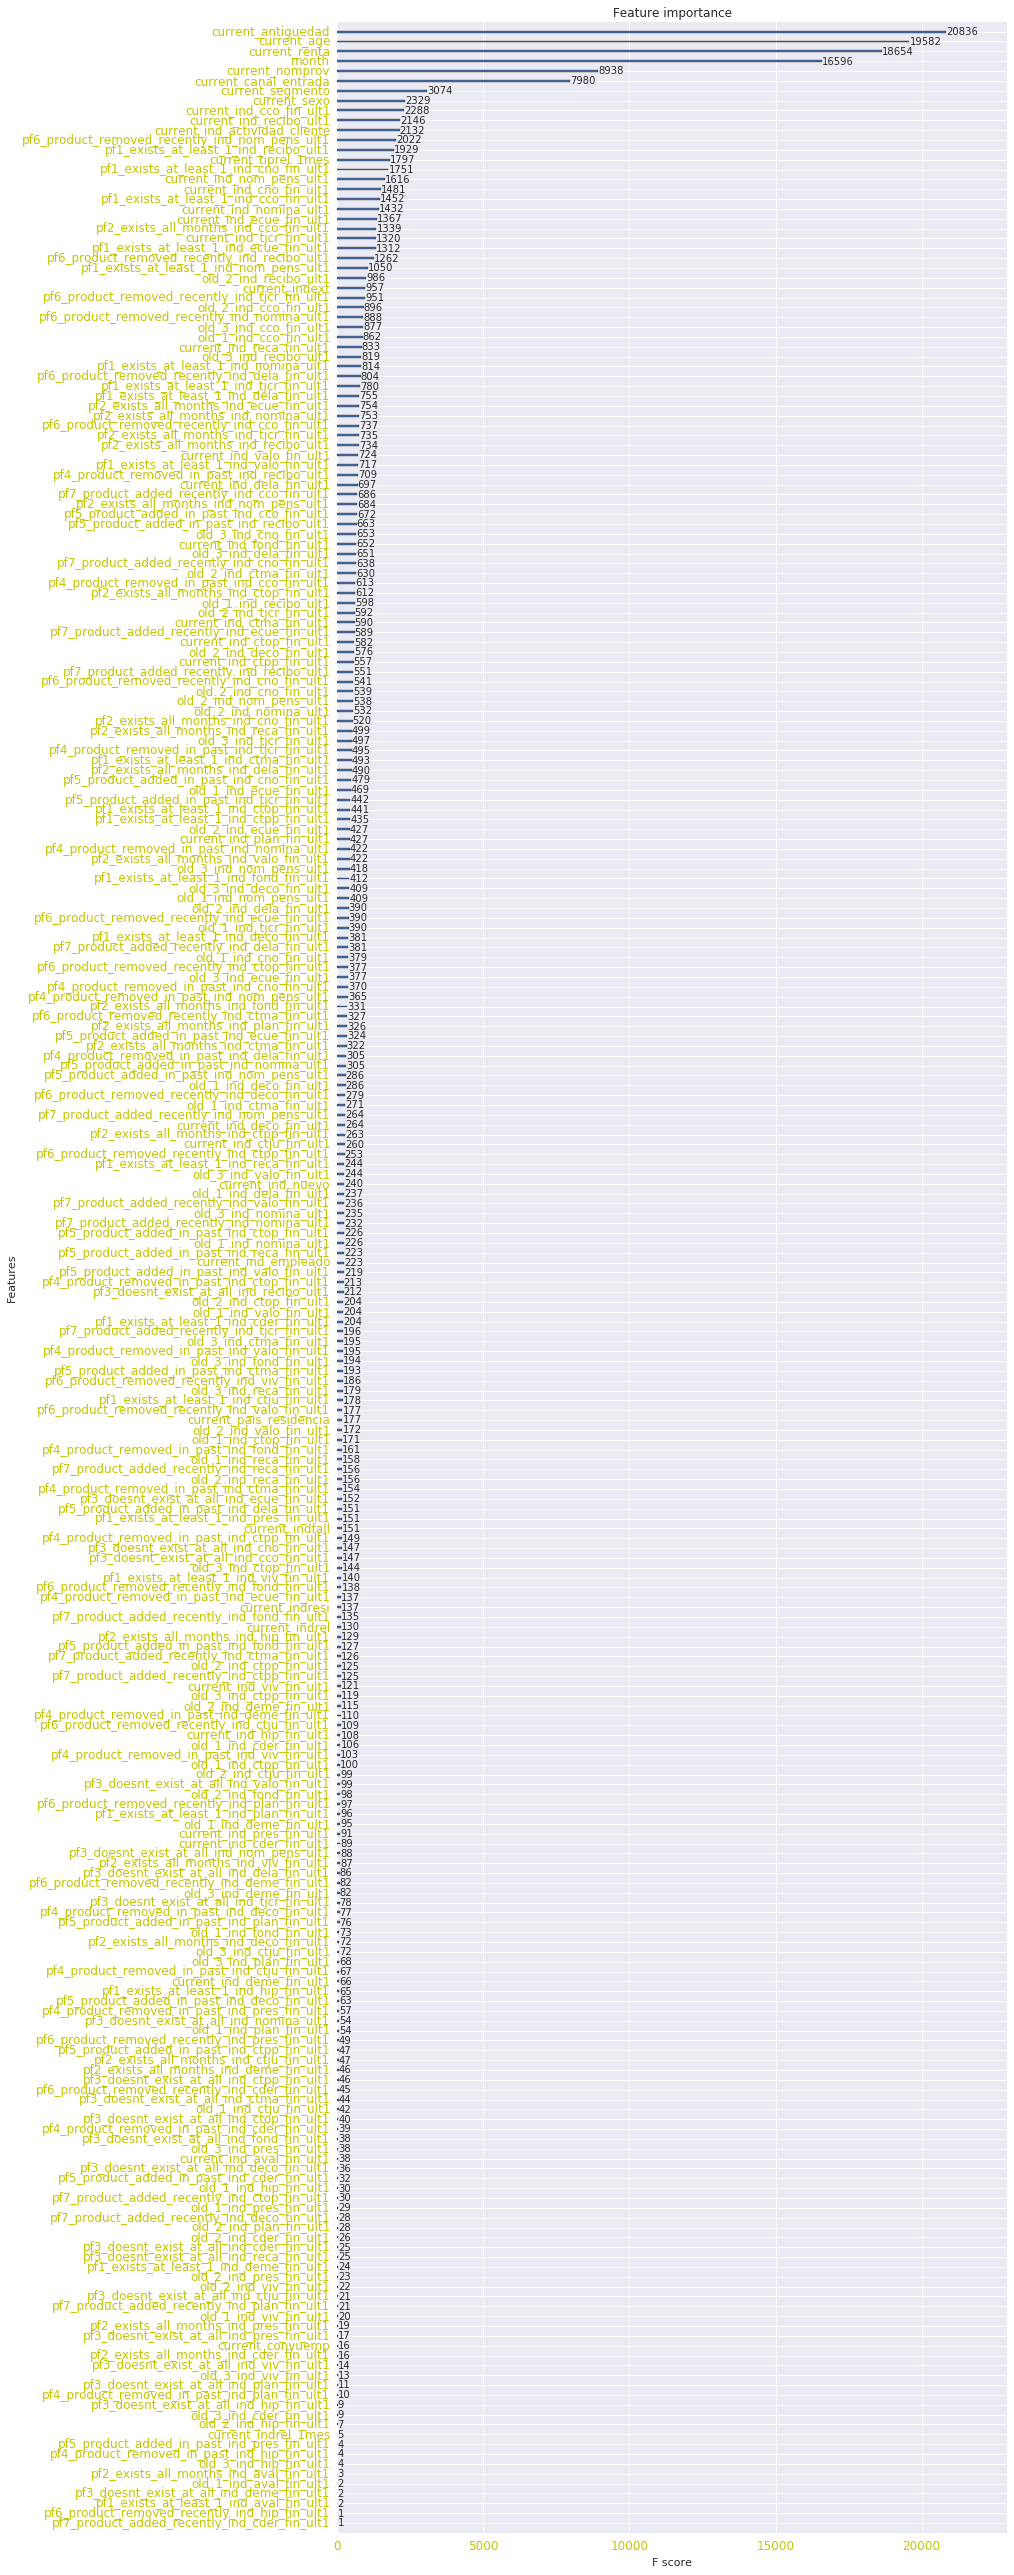

time: 4.95 s


In [44]:
pylab.rcParams['figure.figsize'] = (12, 45)
xgb.plot_importance(bst)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c4c400")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

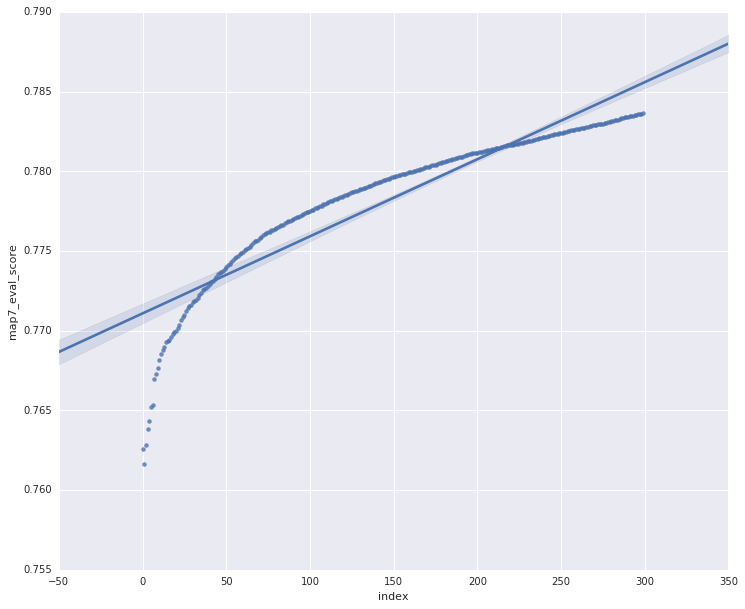

time: 447 ms


In [45]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_eval_score'] = evals_result['train']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
sns.regplot(x='index', y='map7_eval_score', data = p2)

In [46]:
pickle_description = '11.1 Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/11.1xgb_trained_on_all_months_only_added_users_product_features_generated_from_last_4_months.csv.pickle.zip
uploading to s3 done
time: 58.3 s


## Dont forget to commit this notebook